# Projet Neo4j sur la base de données BROT
Yannis BARBA

### Contexte 

Pour ce projet visant à travailler avec une base de données sous forme de graphe avec neo4j, j'ai souhaité mettre à profit cette technologie dans le domaine de l'écologie (étude des populations et des écosystèmes). 

Au cours de mes recherches, j'ai découvert une base de données recensant un grand nombre d'espèce méditérranénnes ainsi que leur traits. Les traits étant des charactéristiques phénotypiques, génétiques ou morphologiques d'un organisme (ref). Les auteurs de cette base de données sont Çağatay Tavşanoğlu & Juli G. Pausas. Ils ont référencé 2457 taxons méditérranéens et un total de 44 traits, pour obtenir au final 25 764 individus, un individu étant la mesure d'un trait pour un taxon donné (tous les traits ne sont pas recensés pour chaque taxons). 

Cette base de données a été constituée de plusieurs manières notamment grâce à des références bibliographiques et des observations expérimentales. Ainsi, pour chaque paire taxon-trait observé, donc pour chaque ligne, il y a également une source bibliographique. 

La base de données est composée en 4 fichiers csv : 

- BROT2_dat.csv (toutes les paires taxon-trait observé)
- BROT2_sou.csv (toutes les sources)
- BROT2_tax.csv (toutes les informations supplémentaires sur les taxons)
- BROT2_syn.csv (tous les synonymes des taxons)

J'ai également décidé de créer un fichier **traits.csv**, permettant d'avoir le nom complet d'un trait et des explications le concernant. Ces informations sont disponibles dans l'article sur lequel j'ai basé mon projet (ref). J'ai décidé de créer ce fichier afin d'avoir l'information directement dans le résultat de mes requêtes et ne pas avoir à me référer systématiquement à l'article pour analyser mes résultats.


## Problématique 
A partir de ce jeu de données, les problématiques possibles sont très nombreuses. D'après l'article ce type de base de données (sur les traits) est très prometteur pour les biologistes afin de comprendre la répartition de populations et la formation d'écosystèmes. 

Une base de donnée sous forme de graphe semble tout à fait adaptée, puisqu'elle permet de visualiser assez aisément les appartenances des taxons aux différentes familles, les taxons possédant tel ou tel trait etc. Par ailleurs au cours de mes recherhces, j'ai pu constater que les bases de données de traits étaient souvent sous forme de graphe. 

Les sujets de réflexions étant vastes, j'ai décidé de me concentrer sur certaines questions que je me suis posé au premier abord en lisant l'article.

Dans un premier temps, comme l'auteur a identifié des traits en lien avec la résillience des plantes au incendie, j'ai décidé de me concentrer sur l'étude de ces traits. En effet, la présence du feu en méditérranée a eu un impact sur le développement des populations y compris végétales. Certaines espèces ont développé des traits traduisant une adaptation à cette pression environnementale particulière. 

Je me suis donc demandé si l'on pouvait identifier un pattern de plantes adpatées à la présence du feu en méditérranée. Comme nous allons le voir par la suite, certains traits sont des mesures directes de l'adaptation aux incendies. Mais je voulais savoir si parmis les plantes qui possèdent ces traits, nous pouvions mettre en évidence d'autres traits qui ne serait pas directement associés à l'adaptation au feu.

##### Connexion à la base de données

In [6]:
from py2neo import *
import pandas as pd
from pandas import DataFrame
graph = Graph("bolt://localhost:7687", auth=("neo4j", "root"))

## Adaptation aux incendies

Afin de répondre à la première probématique posée, il nous faut définir ce que sont les taxons présentants des adaptations aux incendies. A partir de la description des traits dans l'article, j'ai pu définir un ensemble de trait définissant une adaptation aux incendies, la modalité choisie est indiquée en ().

- Fire-stimulated ﬂowering **FireStimFlower** (yes)
- Resprouting capacity after ﬁre **RespFire** (high)
- Chemical germination cues **ChemCues** (stimulation)
- Heat-stimulated germination **HeatStimGerm** (high|LMH)
- Post-ﬁre seedling emergence **SeedlEmerg** (high)
- Post-ﬁre seedling survival **SeedlSurv** (high)

Afin de connaître la description de chacun des traits choisis, nous pouvons interoger la base de données avec une première requête simple. 

In [7]:
fireTraits = ["FireStimFlower", "RespFire", "ChemCues", "HeatStimGerm", "SeedlEmerg", "SeedlSurv"]

for trait in fireTraits:
    rq = '''match(t:Trait {name : $trait}) return t.name as name, t.explanation as explanation'''
    res = graph.run(rq, trait=trait).to_data_frame()
    print("######################")
    print(f"Trait : {res['name'][0]} \n {res['explanation'][0]} \n \n")
    
    

######################
Trait : FireStimFlower 
 Fire-stimulated ï¬owering in post-ï¬re resprouters. 
 

######################
Trait : RespFire 
 Resprouting capacity after one year when most of the plant has been scorched (average proportion of
adult plants that resprout as percentage). Not reported for annual plants (which can be assumed to be
RespFire = no). 
 

######################
Trait : ChemCues 
 Germinative response to smoke (smk), ash (ash), charcoal (cha), nitrogenous compounds like KNO 3
(NC1), NaNO 2 (NC2), NH 4 Cl (NC3), NH 4 HOC 3 (NC4), NH 4 NO 3 (NC5), or response to karrikins
(KAR), cyanohydrins (CYN, including several cyanides, mandelonitrile, and glyceronitrile). The response
in indicated before the vertical bar, and the chemical cue tested, after the vertical bar (e.g. stimulation|
Smk). 
 

######################
Trait : HeatStimGerm 
 The highest intensity in heat treatments (i.e., seed exposition to dry heat > = 50 Â°C) that produce higher
germination than t

Pour des fonctions réutilisées régulièrement, j'ai décidé de créer un fichier db_request

In [8]:
from db_request import *

In [9]:
# PENSER A REMPLACER pd.unique PAR DISTINCT avec NEO4J !!

def allTaxons():
    rq = ''' match(tx:Taxon) return tx.family as family, tx.genus as genre, tx.species as espece'''
    return graph.run(rq).to_data_frame()

allTaxons=allTaxons()
allFamilies=pd.unique(allTaxons["family"])

print(f"Nombre de taxons : {len(allTaxons)}")
print(f"Nombre famille : {len(allFamilies)}")

Nombre de taxons : 2457
Nombre famille : 119


### Identification des familles dont certaines espèces sont adaptées aux incendies

Regardons dans un premier temps tous les taxons ayant au moins une modalité d'un des traits identifié précédemment. C'est à dire les taxons présentant au moins une adaptation au feu.

la modalité *stimulation|smk* pour le trait **ChemCues**, signifie que le taxon voit sa germination stimulée par la fumée.

In [24]:
fireTraits = {
    "FireStimFlower": "yes",
    "RespFire": "high",
    "ChemCues" : "stimulation|smk",
    "HeatStimGerm" : "high|LMH",
    "SeedlEmerg" : "high",
    "SeedlSurv" : "high"
}

def allTaxonAdaptedTo(fireTraits):
    rq = ""
    maxUnion = 0
    for key, value in fireTraits.items():
        rq += f"match(tx:Taxon)<-[:TRAIT_OF_TAXON]-(d:Data {{data: '{value}'}})-[:TYPE_OF_TRAIT]->(t:Trait {{name: '{key}'}}) return tx.taxon as taxon, t.name as trait, d.data as data"
        if(maxUnion < len(fireTraits)-1):
            rq += " UNION "
            maxUnion+=1
    return graph.run(rq).to_data_frame()

allTaxonAdaptedToFire = allTaxonAdaptedTo(fireTraits)
print(allTaxonAdaptedToFire)
print(f"{allTaxonAdaptedToFire.shape[0]} taxons présentent au moins une adaptation au feu")
print(f"soit {round((allTaxonAdaptedToFire.shape[0]/len(allTaxons))*100, 2)}% des taxons")

                     taxon           trait  data
0       Asphodelus ramosus  FireStimFlower   yes
1    Cyclamen hederifolium  FireStimFlower   yes
2        Muscari racemosum  FireStimFlower   yes
3         Urginea maritima  FireStimFlower   yes
4      Narcissus triandrus  FireStimFlower   yes
..                     ...             ...   ...
382    Euphorbia characias       SeedlSurv  high
383   Genista acanthoclada       SeedlSurv  high
384        Fumana laevipes       SeedlSurv  high
385     Micromeria juliana       SeedlSurv  high
386    Trifolium campestre       SeedlSurv  high

[387 rows x 3 columns]
387 taxons présentent au moins une adaptation au feu
soit 15.75% des taxons


N'ayant pas de connaissance préalable sur le sujet (les adaptations des plantes au feu), j'ai décidé d'aborder dans un premier temps une approche dite "naïve", c'est à dire que j'étudie dans un premier temps les différents trait identifés précédemment. 

#### Focus sur tous les traits lié aux incendies

Nous pouvons maintenant regarder pour l'ensemble des traits identifiés comme étant une adadaptation au feu, lequel est le plus représenté. 


In [20]:
for trait, modality in fireTraits.items():
    taxonWithTraitAndMod = allTaxonWithTraitAndModality(trait, modality)
    nbreTaxon = len(taxonWithTraitAndMod)
    perc = round((nbreTaxon/allTaxonAdaptedToFire.shape[0])*100, 2)
    print("###########")
    print(f"{perc}% des taxons présentant une adaptation au feu ont la modalité {modality} pour le trait {trait}")

###########
6.2% des taxons présentant une adaptation au feu ont la modalité yes pour le trait FireStimFlower
###########
30.75% des taxons présentant une adaptation au feu ont la modalité high pour le trait RespFire
###########
22.22% des taxons présentant une adaptation au feu ont la modalité stimulation|smk pour le trait ChemCues
###########
15.5% des taxons présentant une adaptation au feu ont la modalité high|LMH pour le trait HeatStimGerm
###########
47.29% des taxons présentant une adaptation au feu ont la modalité high pour le trait SeedlEmerg
###########
10.59% des taxons présentant une adaptation au feu ont la modalité high pour le trait SeedlSurv


#### Focus sur le trait SeedEmerg

C'est le trait **SeedEmerg** qui est le trait le plus représenté parmi les taxons possédant au moins un trait d'adaptation au feu. C'est pourquoi j'ai décidé de me concentrer d'abord sur ce trait. 

Dans un premier temps, déterminons si les taxons possédant ce trait possédent également d'autres traits d'adaptation au feu. 

In [72]:
colname = [key for key, value in fireTraits.items()]

seedEmergTaxon = allTaxonWithTraitAndModality("SeedlEmerg", "high")

seedEmergTaxonWithTraits = pd.DataFrame(columns=colname)

def ContingenceMatrixToCompare(baseTrait, baseModality, traitsAndModality):
    """Cette fonction retourne une matrice de contingence permettant de déterminer si des taxons possédant 
    un trait et une modalité donnée possède d'autres traits et modalités"""
    
    colname = [key for key, value in traitsAndModality.items()]
    
    taxonFromBaseTrait = allTaxonWithTraitAndModality(baseTrait, baseModality)
    
    matrix = pd.DataFrame(columns=colname)

    for tax in taxonFromBaseTrait["taxon"]:
        mod = {key:0 for key,value in traitsAndModality.items()}
        rq = '''match(tx:Taxon {taxon: $tax})<-[:TRAIT_OF_TAXON]-(d:Data)-[:TYPE_OF_TRAIT]->(t:Trait) return t.name as trait, d.data as modality'''
        allTraits = graph.run(rq, tax=tax).to_data_frame()
        for trait in colname: 
            if allTraits["trait"].isin([trait]).any():         
                if allTraits["modality"][allTraits["trait"][allTraits["trait"] == trait].index[0]]:
                    mod[trait] = 1

        matrix.loc[tax] = [value for key, value in mod.items()]

    return matrix

seedlEmergContingenceMatrix = ContingenceMatrixToCompare("SeedlEmerg", "high", fireTraits)



FireStimFlower      0.00
RespFire           85.00
ChemCues           42.86
HeatStimGerm       34.29
SeedlEmerg        100.00
SeedlSurv          25.00
dtype: float64


<AxesSubplot:>

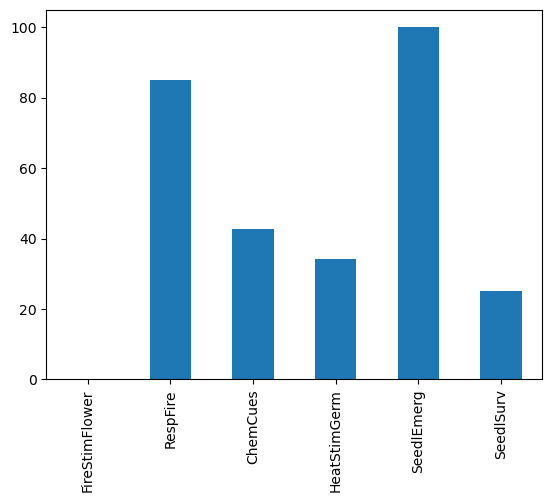

In [90]:
seedlEmergRatio = round((seedlEmergContingenceMatrix.sum(axis="rows")/seedlEmergContingenceMatrix.shape[0])*100,2)
print(seedlEmergRatio)
#seedlEmergRatio.plot(kind="bar")

D'après le graphe ci-dessus, nous pouvons dire que les taxons possédant le trait **SeedlEmerg**, c'est à dire une forte densité d'individu mature un an après un incendie: 

- 85% d'entre eux ont la modalité *"high"* pour le trait **RespFire** qui correspond à la capacité de repousse 1 an après un incendie. Cela semble cohérent, car s'il y a une forte densité de population, c'est bien que les individus ont une forte capacité à la repousse. 

- 42% d'entre eux ont la modalité *"stimulation|smk"* pour le trait **ChemCues**, ce qui veut dire que leur germination est stimulée par le feu, ce qui encore une fois est plutôt logique, mais nous pourrions également regarder quelles sont les modalités pour ce trait afin d'apporter plus de finesse dans l'analyse. 

- 34 % d'entre eux ont la modalité *"high|LMH"*, pour le trait **HeatStimGerm** c'est à dire que la germination est stimulée lors d'une chaleur très importante, c'est à dire supérieure à 100°C pendant plus de 5min. (Attention, dans le cadre de ce projet, j'ai choisi de me concentrer sur une seule modalité par soucis de simplification pour ce trait, mais comme nous pouvons le constater, les modalités sont plus nombreuses, les résultats sont donc à prendre avec des pincettes). 

- 25% ont la modalité *"high"* pour le trait **SeedlSurv**, trait qui correspond à la proportion de graines ayant survécus la première saison sèche après l'incendie. 

- 0 % d'entre eux n'ont la modalité *"yes"* pour le trait **FireStimFlower**, soit ce trait n'a pas été renseigné pour ces espèces, soit, un taxon à une adaptation au feu au niveau de la germination OU au niveau de la floraison mais pas pour les deux en même temps.

#### Focus sur le trait FireStimFlower

In [11]:
fireStimFlower = allTaxonWithTraitAndModality("FireStimFlower", "yes")
fireStimFlowerFamilies = pd.unique(fireStimFlower["famille"])
print(f"Nombre de plante possédant ce trait : {len(fireStimFlower)}")
print(f"Nombre de familles ayant au moins une espèce dont la floraison est stimulée pour les incendies : {len(fireStimFlowerFamilies)}")
print(fireStimFlowerFamilies)

Nombre de plante possédant ce trait : 24
Nombre de familles ayant au moins une espèce dont la floraison est stimulée pour les incendies : 8
['Asphodelaceae' 'Primulaceae' 'Asparagaceae' 'Amaryllidaceae' 'Liliaceae'
 'Dioscoreaceae' 'Araceae' 'Iridaceae']


In [12]:
percentageOfFireStimFlowerFamily = round((len(fireStimFlowerFamilies)/len(allFamilies))*100, 2)
print(f"{percentageOfFireStimFlowerFamily}% des familles possèdent au moins une espèce ayant le trait FireStimFlower")

percentageOfFireStimFlowerTaxon = round((len(fireStimFlower) / len(allTaxons)) * 100, 2)
print(f"{percentageOfFireStimFlowerTaxon}% des taxons ont une floraison stimulée par le feu")

print(f"{round((len(fireStimFlower) / allTaxonAdaptedToFire.shape[0]) * 100, 2)}% des taxons ayant au moins une adapatation au feu ont une floraison stimulée par le feu")

6.72% des familles possèdent au moins une espèce ayant le trait FireStimFlower
0.98% des taxons ont une floraison stimulée par le feu
7.48% des taxons ayant au moins une adapatation au feu ont une floraison stimulée par le feu


Seulement 6% des familles possédent au moins une espèce ayant le trait **FireStimFlower**. 
Et moins d'1% des plantes voient leur floraison stimulée par le feu. 

D'après la documentation, ce trait indique que les plantes le possédant sont capables (voire nécessitent) de fleurir après des incendies. 
Si l'on regarde un peu plus en détail la documentation, il est indiqué que ce sont les plantes géophytes qui présentent le plus ce trait. Une plante géophyte est une plante qui possède un organe permettant de "passer la mauvaise saison" (wikipédia), tel qu'un bulbe ou bien un rhizome. On peut donc regarder la proportion de plantes géophytes dans celle présentant le trait **FireStimFlower**. 

Il existe un trait : **GrowthForm** renseignant les plantes géophytes ou non. 



In [13]:
def modalityOfOneTraitForOneTaxon(taxon, trait):
    rq = '''match(tx:Taxon {taxon: $taxon})<-[:TRAIT_OF_TAXON]-(d:Data)-[:TYPE_OF_TRAIT]->(t:Trait {name: $trait}) return tx.taxon as taxon, d.data as trait'''
    res = graph.run(rq, taxon=taxon, trait=trait).to_data_frame()
    if(len(res) != 0):
        return pd.unique(res["trait"])
    return []

def hasOneOfThisTrait(traits, taxonTraits):
    for t in taxonTraits:
        if t in traits:
            return True
    return False

In [14]:
for el in fireStimFlower["taxon"]:
    print(el, modalityOfOneTraitForOneTaxon(el, "GrowthForm"))

Asphodelus ramosus ['geophyte']
Cyclamen hederifolium ['geophyte']
Muscari racemosum ['geophyte']
Urginea maritima ['geophyte']
Narcissus triandrus ['geophyte']
Narcissus dubius ['geophyte']
Gagea peduncularis ['geophyte']
Dioscorea communis ['geophyte']
Acis nicaeensis ['geophyte']
Ornithogalum narbonense ['geophyte']
Arisarum vulgare ['geophyte']
Gladiolus illyricus ['geophyte']
Iris lutescens ['geophyte']
Lapiedra martinezii ['geophyte']
Gladiolus illyricus ['geophyte']
Romulea tempskyana ['geophyte']
Ornithogalum sphaerocarpum ['geophyte']
Allium hirtovaginatum ['geophyte']
Allium sandrasicum ['geophyte']
Allium amethystinum ['geophyte']
Gagea graeca ['geophyte']
Leopoldia comosa ['geophyte']
Asparagus stipularis ['liana']
Allium stamineum ['geophyte']


Nous pouvons constater qu'a l'exception du taxon "Asparagus stipularis", tous les taxons avec le trait **FireStimFlower** sont en fait des géophytes. 

Nous pouvons regarder combien de plantes sont géophytes dans notre base de données avec de savoir si le fait d'être géophyte suffit pour voir sa floraison stimulé par le feu ou bien s'il faut prendre en compte d'autre caractéres.

In [15]:
allGeophytes = allTaxonWithTraitAndModality("GrowthForm", "geophyte")
print(f"{round((len(fireStimFlower) / len(allGeophytes))*100)} % des geophytes possédent le trait FireStimFlower")

13 % des geophytes possédent le trait FireStimFlower


D'après le résultat précédent, nous pouvons constater que le fait d'être géophyte n'est pas suffisant pour avoir une floraison stimulée par le feu. 

Ce trait ne semble pas être discriminant